# Определение наиболее выгодного региона нефтедобычи

Для добывающей компании «ГлавРосГосНефть» нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

<b>Шаги для выбора локации:</b>

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

<b>Условия задачи:</b>

- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. 
- Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. 
- Среди них выбирают регион с наибольшей средней прибылью.

<b>План действий:</b>

1. Загрузить и подготовить данные. 

2. Обучить и проверить модель для каждого региона:

2.1. Разбить данные на обучающую и валидационную выборки в соотношении 75:25.

2.2. Обучить модель и сделать предсказания на валидационной выборке.

2.3. Сохранить предсказания и правильные ответы на валидационной выборке.

2.4. Оценить средний запас предсказанного сырья и RMSE модели.

2.5. Проанализировать результаты.

3. Расчёт прибыли:

3.1. Сохраните в отдельных переменных все ключевые значения для расчётов. 

3.2. Рассчитать достаточный объём сырья для безубыточной разработки новой скважины. Сравнить полученный объём сырья со средним запасом в каждом регионе.

3.3. Сделать выводы по этапу подготовки расчёта прибыли.

4. Написать функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели:

4.1. Выбрать скважины с максимальными значениями предсказаний.

4.2. Просуммировать целевое значение объёма сырья, соответствующее этим предсказаниям.

4.3. Рассчитать прибыль для полученного объёма сырья.

5. Подсчёт рисков и прибыли для каждого региона:

5.1. Применить технику Bootstrap для 1000 выборок, чтобы найти распределение прибыли.

5.2. Найти среднюю прибыль, 95%-й доверительный интервал и риск убытков. Убыток — это отрицательная прибыль.

5.3. Сделать выводы: предложить регион для разработки скважин и обоснуйте выбор.

## Загрузка и подготовка данных

### Импорт библиотек

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from numpy.random import RandomState

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression

from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

from math import sqrt

from sklearn.preprocessing import StandardScaler 

### Загрузка данных

In [58]:
from google.colab import drive   # подключение гугл-диска
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [59]:
data_path = '/content/drive/MyDrive/_PYTHON/YandexPracticum/Profitable_oil_region/' # путь к датасетам

In [60]:
geo_data_0 = pd.read_csv(data_path+'geo_data_0.csv') # первый регион
geo_data_1 = pd.read_csv(data_path+'geo_data_1.csv') # второй регион
geo_data_2 = pd.read_csv(data_path+'geo_data_2.csv') # третий регион

### Подготовка данных


In [61]:
geo_data_0.head() # первый регион,  так же, как и по другим регионам 

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


`id` — уникальный идентификатор скважины. Он никак не влияет за запасы в скважине, поэтому этот признак можно удалить. Для идентификации достаточно индексов.
`f0`, `f1`, `f2` — три признака точек (неважно, что они означают, но сами признаки значимы);
`product` — объём запасов в скважине (тыс. баррелей). 

In [62]:
geo_data_0.drop(columns={'id'}, inplace=True) # удаляю столбец id
geo_data_1.drop(columns={'id'}, inplace=True) 
geo_data_2.drop(columns={'id'}, inplace=True) 

In [63]:
geo_data_0.info() # первый регион,  так же, как и по другим регионам 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.1 MB


In [64]:
geo_data_0.isna().sum() # первый регион, отсутствующих значений нет, так же, как и по другим регионам 

f0         0
f1         0
f2         0
product    0
dtype: int64

In [65]:
geo_data_0.describe() # первый регион

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


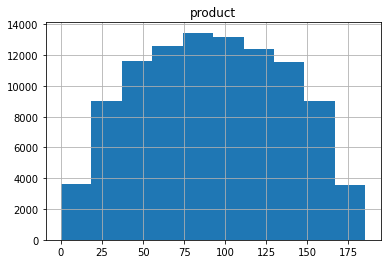

In [66]:
geo_data_0.hist('product'); # первый регион

В первом регионе распределение объёмов запасов в скважине нормальное, вокруг среднего в 92,5 тыс. баррелей. Скважин с нулевыми и максимальными (в 2 раза больше среднего) запасами примерно поровну - по чуть менее 4% из 100 тыс. скважин

In [67]:
geo_data_1.describe() # второй регион

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


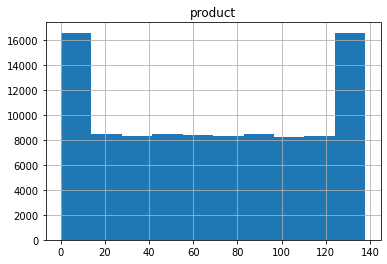

In [68]:
geo_data_1.hist('product'); # второй регион

Во втором регионе распределение объёмов запасов в скважинах не нормальное. Среднее 68,8 тыс. баррелей. Скважин с нулевыми и максимальными (в 2 раза больше среднего) запасами много и примерно поровну - по чуть более 16% из 100 тыс. скважин

In [69]:
geo_data_2.describe() # третий регион

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


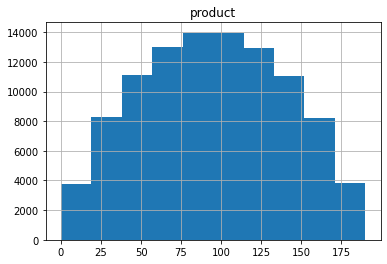

In [70]:
geo_data_2.hist('product'); # третий регион

В третьем регионе, как и в первом, распределение объёмов запасов в скважине нормальное, вокруг среднего в 95 тыс. баррелей. Скважин с нулевыми и максимальными (в 2 раза больше среднего) запасами примерно поровну - по чуть менее 4% из 100 тыс. скважин

## Обучение и проверка модели

In [71]:
RANDOM_STATE = 12345 # константа

In [72]:
def LinearRegressionModel(data):   # модель линейной регрессии
    df_train, df_valid = train_test_split(data, test_size=0.25, random_state=RANDOM_STATE)
    
    features_train = df_train.drop('product', axis=1) # признаки
    target_train = df_train['product']                # целевой признак
    
    features_valid = df_valid.drop('product', axis=1)
    target_valid = df_valid['product']
    
    model = LinearRegression() # модель линейной регрессии
    model.fit(features_train, target_train) # обучение модели
    
    predictions_train = model.predict(features_train) # предсказания на обучающей выборке
    predictions_valid = model.predict(features_valid)# предсказания на валидационной выборке
    
    mae_train = mean_absolute_error(target_train, predictions_train) # Среднее абсолютное отклонение
    mae_valid = mean_absolute_error(target_valid, predictions_valid) # Чем меньше, тем лучше
    
    rmse_train = sqrt(mean_squared_error(target_train, predictions_train)) # RMSE
    rmse_valid = sqrt(mean_squared_error(target_valid, predictions_valid)) # кв.корень из MSE - средней квадратичной ошибки
    
    r2_train = r2_score(target_valid, predictions_valid) # Коэффициент детерминации
    r2_valid = r2_score(target_valid, predictions_valid) # Увеличение метрики означает прирост качества модели
    
    print('     На обучающей выборке   |   На валидационной выборке')
    print('_________________________________________________________')
    print('МАЕ: ', mae_train,'       ', mae_valid)
    print('RMSE:', rmse_train,'        ', rmse_valid)
    print('R2:  ', r2_train,'      ', r2_valid)
    print('_________________________________________________________')
    print('Средний запас предсказанного сырья =', predictions_valid.mean()) 
    print('Средний запас сырья =', target_valid.mean())
    return target_valid, predictions_valid


### Первый регион

In [73]:
geo_target_0, geo_pred_0 = LinearRegressionModel(geo_data_0)

     На обучающей выборке   |   На валидационной выборке
_________________________________________________________
МАЕ:  31.079961075786297         30.919600777151313
RMSE: 37.72999219904026          37.5794217150813
R2:   0.27994321524487786        0.27994321524487786
_________________________________________________________
Средний запас предсказанного сырья = 92.59256778438035
Средний запас сырья = 92.07859674082927


In [74]:
geo_pred_0 # предсказания запасов по первому региону

array([ 95.89495185,  77.57258261,  77.89263965, ...,  61.50983303,
       118.18039721, 118.16939229])

Вывод: средний запас предсказанного сырья в скважине очень близок к среднему по правильным ответам. Модель линейной регрессии делает достаточно точные предсказания.

###  Второй регион

In [75]:
geo_target_1, geo_pred_1 = LinearRegressionModel(geo_data_1)

     На обучающей выборке   |   На валидационной выборке
_________________________________________________________
МАЕ:  0.7168438837861948         0.7187662442124758
RMSE: 0.8894720773917386          0.893099286775617
R2:   0.9996233978805127        0.9996233978805127
_________________________________________________________
Средний запас предсказанного сырья = 68.728546895446
Средний запас сырья = 68.72313602435997


In [76]:
geo_pred_1 # предсказания запасов по второму региону

array([ 82.66331365,  54.43178616,  29.74875995, ..., 137.87934053,
        83.76196568,  53.95846638])

Вывод: здесь модель делает наиболее точные предсказания до 3-го знака после запятой. Связано с тем, что запасы по всем месторождениям в этом регионе равномерные, за исключением двух выбросов.

###  Третий регион

In [77]:
geo_target_2, geo_pred_2 = LinearRegressionModel(geo_data_2)

     На обучающей выборке   |   На валидационной выборке
_________________________________________________________
МАЕ:  32.83941121639209         32.792652105481814
RMSE: 40.06425978832384          40.02970873393434
R2:   0.20524758386040443        0.20524758386040443
_________________________________________________________
Средний запас предсказанного сырья = 94.96504596800489
Средний запас сырья = 94.88423280885438


In [78]:
geo_pred_2 # предсказания запасов по третьему региону

array([ 93.59963303,  75.10515854,  90.06680936, ...,  99.40728116,
        77.77991248, 129.03241718])

Вывод: предсказания чуть более точные, чем для первого региона с похожим распределением запасов.

## Расчёт прибыли

### Ключевые значения для расчётов

In [79]:
RES_POINTS = 500 # research points - количество исследуемых точек 
DEV_POINTS = 200 # development points - количество разрабатываемых точек 
BUDGET = 10000 # бюджет на разработку 200 точек в миллионах рублей
PRODUCT_PRICE = 0.45 # доходность одного барреля в миллионах рублей

### Достаточный объём сырья для безубыточной разработки новой скважины

In [80]:
LOSS_POINT = BUDGET / DEV_POINTS # стоимость разработки
print('Бюджет на разработку одного месторождения:', LOSS_POINT, 'млн рублей')

Бюджет на разработку одного месторождения: 50.0 млн рублей


In [81]:
PROFIT_POINT = BUDGET / DEV_POINTS / PRODUCT_PRICE # точка безубыточности 111,11 баррелей
print('Достаточный объём для безубыточной разработки новой скважины:', round(PROFIT_POINT,2), 'баррелей')

Достаточный объём для безубыточной разработки новой скважины: 111.11 баррелей


### Сравнение достаточного объёма сырья со средним запасом в каждом регионе

In [82]:
geo_data_0['product'].mean(), geo_data_1['product'].mean(), geo_data_2['product'].mean()

(92.50000000000001, 68.82500000000002, 95.00000000000004)

Наибольший средний запас месторождения в третьем регионе. Он меньше, чем достаточный запас для безубыточной разработки скважины. Значит в разработку нужно будет брать скважины третьего региона с запасом сырья выше среднего как минимум на 26 баррелей

In [83]:
geo_pred_0.mean(), geo_pred_1.mean(), geo_pred_2.mean()

(92.59256778438035, 68.728546895446, 94.96504596800489)

### Выбор безубыточных скважин

In [84]:
def geo_max(geo_pred, limit):     # функция выбирающая точки с доходом больше limit из региона geo_pred
    geo_max = []
    for i in range(len(geo_pred)):
        if geo_pred[i] > limit:
            geo_max.append(geo_pred[i])
    return geo_max

In [85]:
geo_max_0 = geo_max(geo_pred_0, PROFIT_POINT) # количество безубыточных скважин из 10000 в первом регионе по предсказанию модели
len(geo_max_0)

5388

In [86]:
geo_max_1 = geo_max(geo_pred_1, PROFIT_POINT) # количество безубыточных скважин из 10000 во втором регионе 
len(geo_max_1)

4594

In [87]:
geo_max_2 = geo_max(geo_pred_2, PROFIT_POINT) # количество безубыточных скважин из 10000 в третьем регионе
len(geo_max_2)

5234

### Функция расчёта прибыли по выбранным скважинам

In [88]:
def geo_profit(geo_pred):  # считает прибыль по выбранным с помощью предсказания модели точкам
    profit = 0
    for i in range(len(geo_pred)):
        profit += geo_pred[i]*PRODUCT_PRICE - LOSS_POINT
    return profit    

In [89]:
geo_profit(geo_max_0) # прибыль по безубыточным месторождениям первого региона

31451.801692968846

In [90]:
geo_profit(geo_max_1) # прибыль по безубыточным месторождениям второго региона

47607.289928071354

In [91]:
geo_profit(geo_max_2) # прибыль по безубыточным месторождениям третьего региона

26333.257591624504

Если бы бюджет позволял разработать все безубыточные месторождения, то нужно было бы выбрать второй регион, где прибыль по всем таким точкам составила бы 47,6 млрд рублей. Но бюджет ограничен - 200 точек.

## Расчёт прибыли и рисков 

### Выбор скважин с максимальными значениями предсказаний

In [92]:
def profit_count(predictions, targets):     # выбирает лучшие 200 точек и считает прибыль по ним
    best_predictions = pd.Series(predictions).sort_values(ascending=False).head(200)
    best_point = targets.iloc[best_predictions.index]
    profit = (PRODUCT_PRICE * best_point.sum()) - BUDGET
    return profit

In [93]:
profit_geo_0 = profit_count(geo_pred_0, geo_target_0)

In [94]:
profit_geo_0 # прибыль по 200 точкам первого региона

3320.8260431398503

In [95]:
profit_geo_1 = profit_count(geo_pred_1, geo_target_1)

In [96]:
profit_geo_1 # прибыль по 200 точкам второго региона

2415.086696681512

In [97]:
profit_geo_2 = profit_count(geo_pred_2, geo_target_2)

In [98]:
profit_geo_2 # прибыль по 200 точкам третьего региона

2710.3499635998323

Наиболее прибыльный получается первый регион, если выбирать только 200 самых прибыльных месторождений

### Функция расчёта прибыли по выбранным скважинам и предсказаниям модели

Выбрать произвольно 500 скважин по каждому региону, у которых объем ещё неизвестен. С помощью модели из 500 выбрать 200 лучших, то есть самых прибыльных. Оценить в каком регионе риски будут минимальны.

In [99]:
def bootstrap(prediction, true_values):
    state = np.random.RandomState(12345)
    values = []
    for i in range(1000):
        sample = pd.Series(prediction).sample(n=500, random_state=state, replace=True)
        values.append(profit_count(sample, true_values))
 
    values = pd.Series(values)
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    # risk = len(values[values < 0]) / len(values)
    risk = (values < 0).mean()
    profit_mean = values.mean()
    return print('от', lower, 'до', upper, '\nПроцент риска {:.2%}'.format(risk),'\nСредняя прибыль:', profit_mean)           

In [100]:
bootstrap(geo_pred_0, geo_target_0) # вероятность убытков по первому региону 

от -111.21554589049533 до 909.7669415534222 
Процент риска 6.90% 
Средняя прибыль: 396.16498480237146


In [101]:
bootstrap(geo_pred_1, geo_target_1)  # вероятность убытков по второму региону меньше 2.5%

от 33.82050939898541 до 852.2894538660361 
Процент риска 1.50% 
Средняя прибыль: 456.04510578666105


In [102]:
bootstrap(geo_pred_2, geo_target_2)  # вероятность убытков по третьему региону 

от -163.35041339560078 до 950.3595749238001 
Процент риска 7.60% 
Средняя прибыль: 404.4038665683571


Минимальные риски и максимальная средняя прибыль получаются по второму региону (geo_data_1)

<b>Выводы: </b>
- Больше всего безубыточных скважин в первом регионе. По предсказанию модели 5123 безубыточных скважины из 10000. 
- Однако прибыль по всем безубыточным скважинам 47,6 млрд рублей больше во втором регионе. И если бы позволял бюджет, то надо было бы разрабатывать все безубыточные скважина во втором регионе.
- Но бюджет ограничен - 200 точек для разработки и 500 произвольных точек из региона для исследования.
- В этом случае минимальный риск 1.50%  и максимальная средняя прибыль получается по второму региону, где прибыль может составить от 33.8 до 852.3 млн рублей